# TAOS mars3D: movies with drifters

In [1]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import xarray as xr
import pandas as pd

import dask
from dask import delayed

from matplotlib import pyplot as plt
%matplotlib inline

import taos.utils as ut
import taos.mars as ms
import taos.drifters as dr

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(processes=4, cores=4) # std
    w = cluster.scale(jobs=2)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: pars

---

## load data subset

In [3]:
files = ms.browse_files()
print("Number of data files = {} ".format(len(files)))

Number of data files = 79103 


In [4]:
# select 4 times spread over 2010
files_selected = [files.loc["2011-{:2d}-03 12:00:00".format(n), "files"] for n in range(1,12, 3)]
ds = xr.concat([xr.open_dataset(f[0]) for f in files_selected], dim="time")

# add vertical coordinate and eos variables
ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
ds = ms.add_eos(ds)

In [5]:
# reload data
drifter_dir = "/home/datawork-lops-osi/aponte/taos/ichthy/lon0p25/"
zarr = os.path.join(drifter_dir, "drifters.zarr")
dsr = xr.open_zarr(zarr)

---

### make figures for movie: surface properties


In [27]:
def gen_fig(f, 
            v=None,
            dsr=None, 
            dr_kwargs=dict(trail_length=1), # in days
            dr_center=None,
            offline=True,
            **kwargs,
           ):
    
    _kwargs = dict(**kwargs)
    #dask.config.set(scheduler="threads")
    
    # load and massage file
    ds = xr.open_dataset(f)

    # add vertical coordinate and eos variables
    ds = ds.assign_coords(z = ms.get_z(ds).transpose("time", "level", "nj", "ni"))
    ds = ms.add_eos(ds)

    #
    out_dir = "/home1/scratch/aponte/figs/"
    fig_path = out_dir+ds.time.dt.strftime("%Y-%m-%d_%H%M%S").values[0]+".png"
    if not offline:
        fig_path=None
    
    if dsr is not None:
        dt = float((ds.time - dsr.date_start)/pd.Timedelta("1D"))
        _dsr = dsr.sel(time=slice(dt-dr_kwargs["trail_length"],dt))        
    
    if dr_center is not None and _dsr.time.size>0:
        if dr_center["center"]=="last":
            lon = float(_dsr.lon.isel(time=-1).mean())
            lat = float(_dsr.lat.isel(time=-1).mean())
        elif dr_center["center"]=="first":
            lon = float(dsr.lon.isel(time=0).mean())
            lat = float(dsr.lat.isel(time=0).mean())
        dlon = dr_center["dlon"]/2
        dlat = dr_center["dlat"]/2
        zoom = [lon-dlon, lon+dlon, max(lat-dlat,49.25), min(lat+dlat, 50)]
        _kwargs.update(zoom=zoom)
    
    fac = ms.plot_bs(ds[v].sel(level=0, method="nearest"),
                     title=v+" @ surface, "+str(ds.time.dt.strftime("%Y-%m-%d %H:%M:%S").values),
                     offline=offline,
                     **_kwargs,
                    )
        
    if dsr is not None and _dsr.time.size>0:
        ax = fac["ax"]
        ax.plot(_dsr.lon, _dsr.lat, color="0.5", transform=ms.ccrs.PlateCarree())
        ax.plot(_dsr.lon.isel(time=-1), _dsr.lat.isel(time=-1), "o",
                markersize=5,
                color="k", 
                transform=ms.ccrs.PlateCarree(),
               )
    
    if fig_path is not None:
        fac["fig"].savefig(fig_path, dpi=150) #bbox_inches = "tight"
        plt.close(fac["fig"])
        
    return fig_path

from dask.delayed import delayed
delayed_fig = delayed(gen_fig)

In [33]:
#
date_start = "2013-01-01"
time_delta = "20D"
lat_start = 49.4

start = pd.Timestamp(date_start)
end = start+pd.Timedelta(time_delta)

file_subset = files[start:end]
dsr_subset = (dsr
              .sel(date_start=date_start, lat_start=lat_start, method="nearest")
              .isel(drifter=slice(0,None,20))
              .squeeze()
              [["lon", "lat"]]
              .compute()
             )

#kwargs = dict(v="TEMP", cmap=ms.cm.thermal)
kwargs = dict(v="SAL", vmin=30, vmax=35, cmap=ms.cm.haline)

_lat = float(dsr_subset["lat"].mean())
lon_sc = np.cos(np.pi/180.*_lat)
dr_center = dict(center="last", dlon=0.4/lon_sc, dlat=0.4)
#dr_center = dict(center="first", dlon=1./lon_sc, dlat=1.)
kwargs.update(**dict(dsr=dsr_subset, dr_center=dr_center), figsize=(5,5))

/dev/shm/pbs.8164149.datarmor0/ipykernel_33980/3609513153.py:9: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  file_subset = files[start:end]
/dev/shm/pbs.8164149.datarmor0/ipykernel_33980/3609513153.py:9: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  file_subset = files[start:end]


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

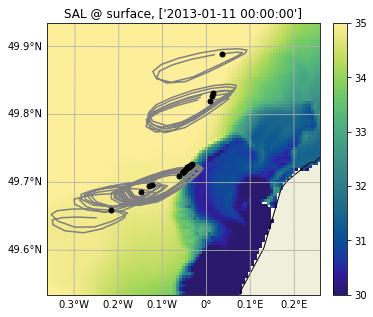

In [34]:
# dev
i = 24*10
f = file_subset.iloc[i,0]
gen_fig(f, offline=False, **kwargs)

In [35]:
#
Nb = len(client.nthreads())
rg = range(0, file_subset.size)
if len(rg)/Nb>1:
    II = np.array_split(rg,len(rg)/Nb)
else:
    II = [list(rg)]
print('%d batches to be done'%len(II))

for I in tqdm(II):
    #print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(file_subset.iloc[i,0], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

print(" ! done !")

34 batches to be done


100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

 ! done !


---

In [46]:
client.restart()

<Client: 'tcp://10.148.0.230:47356' processes=0 threads=0, memory=0 B>

In [6]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 

In [15]:
for f in futures:
    f.cancel()